In [ ]:
!pip install dalle2-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.4/653.4 kB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 70.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 84.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

DLL-E2 IS AN ADVANCE VERSION OF THE DALE -e LANGUAGE MODEL DEVELOPED BY OPEN AI WHICH CAN GENERATE IAMGE FROM TEXTURAL DESCRIPTION.TO TRAIN DALLE_2 IS A 3 STEPP PROCESS, WITH THE TRANING OF CLIP BEING THE MOST IMPORTANT.

To train CLIP, you can either use x-clip package or join LAION discord, where a lot of replication effort are already under way

In [ ]:
import torch
from dalle2_pytorch import CLIP

clip = CLIP(
    dim_text = 512,
    dim_image = 512,
    dim_latent = 512,
    num_text_tokens = 49408,
    text_enc_depth = 1,
    text_seq_len = 256,
    text_heads = 8,
    visual_enc_depth = 1,
    visual_image_size = 256,
    visual_patch_size = 32,
    visual_heads = 8,
    use_all_token_embeds = True,            # whether to use fine-grained contrastive learning (FILIP)
    decoupled_contrastive_learning = True,  # use decoupled contrastive learning (DCL) objective function, removing positive pairs from the denominator of the InfoNCE loss (CLOOB + DCL)
    extra_latent_projection = True,         # whether to use separate projections for text-to-image vs image-to-text comparisons (CLOOB)
    use_visual_ssl = True,                  # whether to do self supervised learning on images
    visual_ssl_type = 'simclr',             # can be either 'simclr' or 'simsiam', depending on using DeCLIP or SLIP
    use_mlm = False,                        # use masked language learning (MLM) on text (DeCLIP)
    text_ssl_loss_weight = 0.05,            # weight for text MLM loss
    image_ssl_loss_weight = 0.05            # weight for image self-supervised learning loss
).cuda()

# mock data

text = torch.randint(0, 49408, (4, 256)).cuda()
images = torch.randn(4, 3, 256, 256).cuda()

# train

loss = clip(
    text,
    images,
    return_loss = True              # needs to be set to True to return contrastive loss
)

loss.backward()

# do the above with as many texts and images as possible in a loop

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Then, you will need to train the decoder, which learns to generate images based on the image embedding coming from the trained CLIP above

In [ ]:
import torch
from dalle2_pytorch import Unet, Decoder, CLIP

# trained clip from step 1

clip = CLIP(
    dim_text = 512,
    dim_image = 512,
    dim_latent = 512,
    num_text_tokens = 49408,
    text_enc_depth = 1,
    text_seq_len = 256,
    text_heads = 8,
    visual_enc_depth = 1,
    visual_image_size = 256,
    visual_patch_size = 32,
    visual_heads = 8
).cuda()

# unet for the decoder

unet = Unet(
    dim = 128,
    image_embed_dim = 512,
    cond_dim = 128,
    channels = 3,
    dim_mults=(1, 2, 4, 8)
).cuda()

# decoder, which contains the unet and clip

decoder = Decoder(
    unet = unet,
    clip = clip,
    timesteps = 100,
    image_cond_drop_prob = 0.1,
    text_cond_drop_prob = 0.5
).cuda()

# mock images (get a lot of this)

images = torch.randn(4, 3, 256, 256).cuda()

# feed images into decoder

loss = decoder(images)
loss.backward()

# do the above for many many many many steps
# then it will learn to generate images based on the CLIP image embeddings

Finally, the main contribution of the paper. The repository offers the diffusion prior network. It takes the CLIP text embeddings and tries to generate the CLIP image embeddings. Again, you will need the trained CLIP from the first step

In [ ]:
import torch
from dalle2_pytorch import DiffusionPriorNetwork, DiffusionPrior, CLIP

# get trained CLIP from step one

clip = CLIP(
    dim_text = 512,
    dim_image = 512,
    dim_latent = 512,
    num_text_tokens = 49408,
    text_enc_depth = 6,
    text_seq_len = 256,
    text_heads = 8,
    visual_enc_depth = 6,
    visual_image_size = 256,
    visual_patch_size = 32,
    visual_heads = 8,
).cuda()

# setup prior network, which contains an autoregressive transformer

prior_network = DiffusionPriorNetwork(
    dim = 512,
    depth = 6,
    dim_head = 64,
    heads = 8
).cuda()

# diffusion prior network, which contains the CLIP and network (with transformer) above

diffusion_prior = DiffusionPrior(
    net = prior_network,
    clip = clip,
    timesteps = 100,
    cond_drop_prob = 0.2
).cuda()

# mock data

text = torch.randint(0, 49408, (4, 256)).cuda()
images = torch.randn(4, 3, 256, 256).cuda()

# feed text and images into diffusion prior network

loss = diffusion_prior(text, images)
loss.backward()

# do the above for many many many steps
# now the diffusion prior can generate image embeddings from the text embeddings

In the paper, they actually used a recently discovered technique, from Jonathan Ho himself (original author of DDPMs, the core technique used in DALL-E v2) for high resolution image synthesis.

This can easily be used within this framework as so

In [ ]:
import torch
from dalle2_pytorch import Unet, Decoder, CLIP

# trained clip from step 1

clip = CLIP(
    dim_text = 512,
    dim_image = 512,
    dim_latent = 512,
    num_text_tokens = 49408,
    text_enc_depth = 6,
    text_seq_len = 256,
    text_heads = 8,
    visual_enc_depth = 6,
    visual_image_size = 256,
    visual_patch_size = 32,
    visual_heads = 8
).cuda()

# 2 unets for the decoder (a la cascading DDPM)

unet1 = Unet(
    dim = 32,
    image_embed_dim = 512,
    cond_dim = 128,
    channels = 3,
    dim_mults = (1, 2, 4, 8)
).cuda()

unet2 = Unet(
    dim = 32,
    image_embed_dim = 512,
    cond_dim = 128,
    channels = 3,
    dim_mults = (1, 2, 4, 8, 16)
).cuda()

# decoder, which contains the unet(s) and clip

decoder = Decoder(
    clip = clip,
    unet = (unet1, unet2),            # insert both unets in order of low resolution to highest resolution (you can have as many stages as you want here)
    image_sizes = (256, 512),         # resolutions, 256 for first unet, 512 for second. these must be unique and in ascending order (matches with the unets passed in)
    timesteps = 1000,
    image_cond_drop_prob = 0.1,
    text_cond_drop_prob = 0.5
).cuda()

# mock images (get a lot of this)

images = torch.randn(4, 3, 512, 512).cuda()

# feed images into decoder, specifying which unet you want to train
# each unet can be trained separately, which is one of the benefits of the cascading DDPM scheme

loss = decoder(images, unet_number = 1)
loss.backward()

loss = decoder(images, unet_number = 2)
loss.backward()

# do the above for many steps for both unets

Finally, to generate the DALL-E2 images from text. Insert the trained DiffusionPrior as well as the Decoder (which wraps CLIP, the causal transformer, and unet(s))

In [ ]:
import torch
from dalle2_pytorch import Unet, Decoder, CLIP

# trained clip from step 1

clip = CLIP(
    dim_text = 512,
    dim_image = 512,
    dim_latent = 512,
    num_text_tokens = 49408,
    text_enc_depth = 6,
    text_seq_len = 256,
    text_heads = 8,
    visual_enc_depth = 6,
    visual_image_size = 256,
    visual_patch_size = 32,
    visual_heads = 8
).cuda()

# 2 unets for the decoder (a la cascading DDPM)

unet1 = Unet(
    dim = 32,
    image_embed_dim = 512,
    cond_dim = 128,
    channels = 3,
    dim_mults = (1, 2, 4, 8)
).cuda()

unet2 = Unet(
    dim = 32,
    image_embed_dim = 512,
    cond_dim = 128,
    channels = 3,
    dim_mults = (1, 2, 4, 8, 16)
).cuda()

# decoder, which contains the unet(s) and clip

decoder = Decoder(
    clip = clip,
    unet = (unet1, unet2),            # insert both unets in order of low resolution to highest resolution (you can have as many stages as you want here)
    image_sizes = (256, 512),         # resolutions, 256 for first unet, 512 for second. these must be unique and in ascending order (matches with the unets passed in)
    timesteps = 1000,
    image_cond_drop_prob = 0.1,
    text_cond_drop_prob = 0.5
).cuda()

# mock images (get a lot of this)

images = torch.randn(4, 3, 512, 512).cuda()

# feed images into decoder, specifying which unet you want to train
# each unet can be trained separately, which is one of the benefits of the cascading DDPM scheme

loss = decoder(images, unet_number = 1)
loss.backward()

loss = decoder(images, unet_number = 2)
loss.backward()

# do the above for many steps for both unets

In [ ]:
from dalle2_pytorch import DALLE2

dalle2 = DALLE2(
    prior=diffusion_prior,
    decoder=decoder
)
texts = ['glistening morning dew on a flower petal']
images = dalle2(texts) # (1, 3, 256, 256)



sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

That's it!

Let's see the whole script below



In [ ]:
import torch
from dalle2_pytorch import DALLE2, DiffusionPriorNetwork, DiffusionPrior, Unet, Decoder, CLIP

clip = CLIP(
    dim_text = 512,
    dim_image = 512,
    dim_latent = 512,
    num_text_tokens = 49408,
    text_enc_depth = 6,
    text_seq_len = 256,
    text_heads = 8,
    visual_enc_depth = 6,
    visual_image_size = 256,
    visual_patch_size = 32,
    visual_heads = 8
).cuda()

# mock data

text = torch.randint(0, 49408, (4, 256)).cuda()
images = torch.randn(4, 3, 256, 256).cuda()

# train

loss = clip(
    text,
    images,
    return_loss = True
)

loss.backward()

# do above for many steps ...

# prior networks (with transformer)

prior_network = DiffusionPriorNetwork(
    dim = 512,
    depth = 6,
    dim_head = 64,
    heads = 8
).cuda()

diffusion_prior = DiffusionPrior(
    net = prior_network,
    clip = clip,
    timesteps = 1000,
    sample_timesteps = 64,
    cond_drop_prob = 0.2
).cuda()

loss = diffusion_prior(text, images)
loss.backward()

# do above for many steps ...

# decoder (with unet)

unet1 = Unet(
    dim = 128,
    image_embed_dim = 512,
    text_embed_dim = 512,
    cond_dim = 128,
    channels = 3,
    dim_mults=(1, 2, 4, 8),
    cond_on_text_encodings = True    # set to True for any unets that need to be conditioned on text encodings
).cuda()

unet2 = Unet(
    dim = 16,
    image_embed_dim = 512,
    cond_dim = 128,
    channels = 3,
    dim_mults = (1, 2, 4, 8, 16)
).cuda()

decoder = Decoder(
    unet = (unet1, unet2),
    image_sizes = (128, 256),
    clip = clip,
    timesteps = 100,
    image_cond_drop_prob = 0.1,
    text_cond_drop_prob = 0.5
).cuda()

for unet_number in (1, 2):
    loss = decoder(images, text = text, unet_number = unet_number) # this can optionally be decoder(images, text) if you wish to condition on the text encodings as well, though it was hinted in the paper it didn't do much
    loss.backward()

# do above for many steps

dalle2 = DALLE2(
    prior = diffusion_prior,
    decoder = decoder
)

images = dalle2(
    ['cute puppy chasing after a squirrel'],
    cond_scale = 2. # classifier free guidance strength (> 1 would strengthen the condition)
)


# save your image (in this example, of size 256x256)

sampling loop time step:   0%|          | 0/63 [00:00<?, ?it/s]

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
import torchvision.utils as vutils

# assuming `images` is a tensor of size (batch_size, channels, height, width)
image = images[0].detach().cpu()
image = (image + 1) / 2 # unnormalize the image
vutils.save_image(image, 'generated_image.png', normalize=False, scale_each=False)


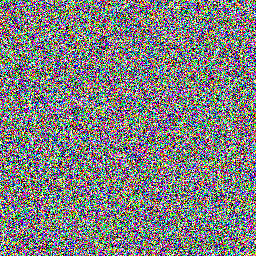

In [ ]:
from IPython.display import Image, display

# Assuming images is a PyTorch tensor of shape (N, C, H, W)
vutils.save_image(images, 'generated_image.png', normalize=True)

display(Image(filename='generated_image.png'))


sampling loop time step:   0%|          | 0/63 [00:00<?, ?it/s]

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

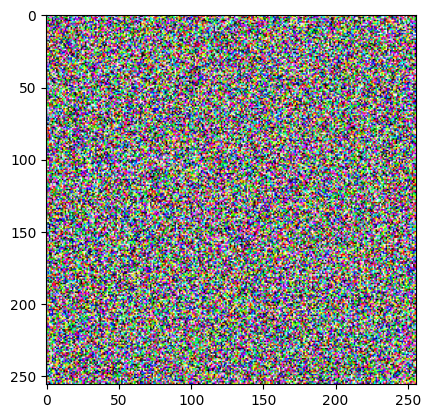

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# generate the image using DALLE2
dalle2 = DALLE2(
    prior = diffusion_prior,
    decoder = decoder
)
images = dalle2(
    ['Tree'],
    cond_scale = 2. # classifier free guidance strength (> 1 would strengthen the condition)
)

# convert the tensor image to a numpy array and reshape it
img_array = images[0].cpu().numpy().transpose(1,2,0)
img_array = np.clip(img_array, 0, 1)
plt.imshow(img_array)
plt.show()


In [ ]:
import torch
from dalle2_pytorch import DiffusionPriorNetwork, DiffusionPrior, CLIP

# get trained CLIP from step one

clip = CLIP(
    dim_text = 512,
    dim_image = 512,
    dim_latent = 512,
    num_text_tokens = 49408,
    text_enc_depth = 6,
    text_seq_len = 256,
    text_heads = 8,
    visual_enc_depth = 6,
    visual_image_size = 256,
    visual_patch_size = 32,
    visual_heads = 8,
).cuda()

# setup prior network, which contains an autoregressive transformer

prior_network = DiffusionPriorNetwork(
    dim = 512,
    depth = 6,
    dim_head = 64,
    heads = 8
).cuda()

# diffusion prior network, which contains the CLIP and network (with transformer) above

diffusion_prior = DiffusionPrior(
    net = prior_network,
    clip = clip,
    timesteps = 100,
    cond_drop_prob = 0.2,
    condition_on_text_encodings = False  # this probably should be true, but just to get Laion started
).cuda()

# mock data

text = torch.randint(0, 49408, (4, 256)).cuda()
images = torch.randn(4, 3, 256, 256).cuda()

# precompute the text and image embeddings
# here using the diffusion prior class, but could be done with CLIP alone

clip_image_embeds = diffusion_prior.clip.embed_image(images).image_embed
clip_text_embeds = diffusion_prior.clip.embed_text(text).text_embed

# feed text and images into diffusion prior network

loss = diffusion_prior(
    text_embed = clip_text_embeds,
    image_embed = clip_image_embeds
)

loss.backward()

# do the above for many many many steps
# now the diffusion prior can generate image embeddings from the text embeddings

In [ ]:
import torch
from dalle2_pytorch import DiffusionPriorNetwork, DiffusionPrior

# setup prior network, which contains an autoregressive transformer

prior_network = DiffusionPriorNetwork(
    dim = 512,
    depth = 6,
    dim_head = 64,
    heads = 8
).cuda()

# diffusion prior network, which contains the CLIP and network (with transformer) above

diffusion_prior = DiffusionPrior(
    net = prior_network,
    image_embed_dim = 512,               # this needs to be set
    timesteps = 100,
    cond_drop_prob = 0.2,
    condition_on_text_encodings = False  # this probably should be true, but just to get Laion started
).cuda()

# mock data

text = torch.randint(0, 49408, (4, 256)).cuda()
images = torch.randn(4, 3, 256, 256).cuda()

# precompute the text and image embeddings
# here using the diffusion prior class, but could be done with CLIP alone

clip_image_embeds = torch.randn(4, 512).cuda()
clip_text_embeds = torch.randn(4, 512).cuda()

# feed text and images into diffusion prior network

loss = diffusion_prior(
    text_embed = clip_text_embeds,
    image_embed = clip_image_embeds
)

loss.backward()

# do the above for many many many steps
# now the diffusion prior can generate image embeddings from the text embeddings

In [ ]:
import torch
from dalle2_pytorch import DALLE2, DiffusionPriorNetwork, DiffusionPrior, Unet, Decoder, OpenAIClipAdapter

# openai pretrained clip - defaults to ViT-B/32

clip = OpenAIClipAdapter()

# mock data

text = torch.randint(0, 49408, (4, 256)).cuda()
images = torch.randn(4, 3, 256, 256).cuda()

# prior networks (with transformer)

prior_network = DiffusionPriorNetwork(
    dim = 512,
    depth = 6,
    dim_head = 64,
    heads = 8
).cuda()

diffusion_prior = DiffusionPrior(
    net = prior_network,
    clip = clip,
    timesteps = 100,
    cond_drop_prob = 0.2
).cuda()

loss = diffusion_prior(text, images)
loss.backward()

# do above for many steps ...

# decoder (with unet)

unet1 = Unet(
    dim = 128,
    image_embed_dim = 512,
    cond_dim = 128,
    channels = 3,
    dim_mults=(1, 2, 4, 8),
    text_embed_dim = 512,
    cond_on_text_encodings = True  # set to True for any unets that need to be conditioned on text encodings (ex. first unet in cascade)
).cuda()

unet2 = Unet(
    dim = 16,
    image_embed_dim = 512,
    cond_dim = 128,
    channels = 3,
    dim_mults = (1, 2, 4, 8, 16)
).cuda()

decoder = Decoder(
    unet = (unet1, unet2),
    image_sizes = (128, 256),
    clip = clip,
    timesteps = 1000,
    sample_timesteps = (250, 27),
    image_cond_drop_prob = 0.1,
    text_cond_drop_prob = 0.5
).cuda()

for unet_number in (1, 2):
    loss = decoder(images, text = text, unet_number = unet_number) # this can optionally be decoder(images, text) if you wish to condition on the text encodings as well, though it was hinted in the paper it didn't do much
    loss.backward()

# do above for many steps

dalle2 = DALLE2(
    prior = diffusion_prior,
    decoder = decoder
)

images = dalle2(
    ['a butterfly trying to escape a tornado'],
    cond_scale = 2. # classifier free guidance strength (> 1 would strengthen the condition)
)

# save your image (in this example, of size 256x256)

100%|███████████████████████████████████████| 354M/354M [00:06<00:00, 50.9MiB/s]


sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/27 [00:00<?, ?it/s]

In [ ]:
!pip install open-clip-torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from dalle2_pytorch import OpenClipAdapter

clip = OpenClipAdapter('ViT-H/14')

In [ ]:
import torch
from dalle2_pytorch import Unet, Decoder, CLIP

# trained clip from step 1

clip = CLIP(
    dim_text = 512,
    dim_image = 512,
    dim_latent = 512,
    num_text_tokens = 49408,
    text_enc_depth = 6,
    text_seq_len = 256,
    text_heads = 8,
    visual_enc_depth = 6,
    visual_image_size = 256,
    visual_patch_size = 32,
    visual_heads = 8
).cuda()

# 2 unets for the decoder (a la cascading DDPM)

unet = Unet(
    dim = 16,
    image_embed_dim = 512,
    cond_dim = 128,
    channels = 3,
    dim_mults = (1, 1, 1, 1)
).cuda()


# decoder, which contains the unet(s) and clip

decoder = Decoder(
    clip = clip,
    unet = (unet,),               # insert both unets in order of low resolution to highest resolution (you can have as many stages as you want here)
    image_sizes = (256,),         # resolutions, 256 for first unet, 512 for second. these must be unique and in ascending order (matches with the unets passed in)
    timesteps = 1000,
    image_cond_drop_prob = 0.1,
    text_cond_drop_prob = 0.5
).cuda()

# mock images (get a lot of this)

images = torch.randn(4, 3, 256, 256).cuda()

# feed images into decoder, specifying which unet you want to train
# each unet can be trained separately, which is one of the benefits of the cascading DDPM scheme

loss = decoder(images, unet_number = 1)
loss.backward()

# do the above for many steps for both unets

mock_image_embed = torch.randn(1, 512).cuda()

# then to do inpainting

inpaint_image = torch.randn(1, 3, 256, 256).cuda()      # (batch, channels, height, width)
inpaint_mask = torch.ones(1, 256, 256).bool().cuda()    # (batch, height, width)

inpainted_images = decoder.sample(
    image_embed = mock_image_embed,
    inpaint_image = inpaint_image,    # just pass in the inpaint image
    inpaint_mask = inpaint_mask       # and the mask
)

inpainted_images.shape # (1, 3, 256, 256)

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1, 3, 256, 256])

In [ ]:
import torch
from dalle2_pytorch import Unet, Decoder, CLIP, VQGanVAE

# trained clip from step 1

clip = CLIP(
    dim_text = 512,
    dim_image = 512,
    dim_latent = 512,
    num_text_tokens = 49408,
    text_enc_depth = 1,
    text_seq_len = 256,
    text_heads = 8,
    visual_enc_depth = 1,
    visual_image_size = 256,
    visual_patch_size = 32,
    visual_heads = 8
)

# 3 unets for the decoder (a la cascading DDPM)

# first two unets are doing latent diffusion
# vqgan-vae must be trained beforehand

vae1 = VQGanVAE(
    dim = 32,
    image_size = 256,
    layers = 3,
    layer_mults = (1, 2, 4)
)

vae2 = VQGanVAE(
    dim = 32,
    image_size = 512,
    layers = 3,
    layer_mults = (1, 2, 4)
)

unet1 = Unet(
    dim = 32,
    image_embed_dim = 512,
    cond_dim = 128,
    channels = 3,
    sparse_attn = True,
    sparse_attn_window = 2,
    dim_mults = (1, 2, 4, 8)
)

unet2 = Unet(
    dim = 32,
    image_embed_dim = 512,
    channels = 3,
    dim_mults = (1, 2, 4, 8, 16),
    cond_on_image_embeds = True,
    cond_on_text_encodings = False
)

unet3 = Unet(
    dim = 32,
    image_embed_dim = 512,
    channels = 3,
    dim_mults = (1, 2, 4, 8, 16),
    cond_on_image_embeds = True,
    cond_on_text_encodings = False,
    attend_at_middle = False
)

# decoder, which contains the unet(s) and clip

decoder = Decoder(
    clip = clip,
    vae = (vae1, vae2),                # latent diffusion for unet1 (vae1) and unet2 (vae2), but not for the last unet3
    unet = (unet1, unet2, unet3),      # insert unets in order of low resolution to highest resolution (you can have as many stages as you want here)
    image_sizes = (256, 512, 1024),    # resolutions, 256 for first unet, 512 for second, 1024 for third
    timesteps = 100,
    image_cond_drop_prob = 0.1,
    text_cond_drop_prob = 0.5
).cuda()

# mock images (get a lot of this)

images = torch.randn(1, 3, 1024, 1024).cuda()

# feed images into decoder, specifying which unet you want to train
# each unet can be trained separately, which is one of the benefits of the cascading DDPM scheme

with decoder.one_unet_in_gpu(1):
    loss = decoder(images, unet_number = 1)
    loss.backward()

with decoder.one_unet_in_gpu(2):
    loss = decoder(images, unet_number = 2)
    loss.backward()

with decoder.one_unet_in_gpu(3):
    loss = decoder(images, unet_number = 3)
    loss.backward()

# do the above for many steps for both unets

# then it will learn to generate images based on the CLIP image embeddings

# chaining the unets from lowest resolution to highest resolution (thus cascading)

mock_image_embed = torch.randn(1, 512).cuda()
images = decoder.sample(mock_image_embed) # (1, 3, 1024, 1024)

In [ ]:
import torch
from dalle2_pytorch import DALLE2, Unet, Decoder, CLIP, DecoderTrainer

clip = CLIP(
    dim_text = 512,
    dim_image = 512,
    dim_latent = 512,
    num_text_tokens = 49408,
    text_enc_depth = 6,
    text_seq_len = 256,
    text_heads = 8,
    visual_enc_depth = 6,
    visual_image_size = 256,
    visual_patch_size = 32,
    visual_heads = 8
).cuda()

# mock data

text = torch.randint(0, 49408, (32, 256)).cuda()
images = torch.randn(32, 3, 256, 256).cuda()

# decoder (with unet)

unet1 = Unet(
    dim = 128,
    image_embed_dim = 512,
    text_embed_dim = 512,
    cond_dim = 128,
    channels = 3,
    dim_mults=(1, 2, 4, 8),
    cond_on_text_encodings = True,
).cuda()

unet2 = Unet(
    dim = 16,
    image_embed_dim = 512,
    cond_dim = 128,
    channels = 3,
    dim_mults = (1, 2, 4, 8, 16),
).cuda()

decoder = Decoder(
    unet = (unet1, unet2),
    image_sizes = (128, 256),
    clip = clip,
    timesteps = 1000
).cuda()

decoder_trainer = DecoderTrainer(
    decoder,
    lr = 3e-4,
    wd = 1e-2,
    ema_beta = 0.99,
    ema_update_after_step = 1000,
    ema_update_every = 10,
)

for unet_number in (1, 2):
    loss = decoder_trainer(
        images,
        text = text,
        unet_number = unet_number, # which unet to train on
        max_batch_size = 4         # gradient accumulation - this sets the maximum batch size in which to do forward and backwards pass - for this example 32 / 4 == 8 times
    )

    decoder_trainer.update(unet_number) # update the specific unet as well as its exponential moving average

# after much training
# you can sample from the exponentially moving averaged unets as so

mock_image_embed = torch.randn(32, 512).cuda()
images = decoder_trainer.sample(image_embed = mock_image_embed, text = text) # (4, 3, 256, 256)

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
import torch
from dalle2_pytorch import DALLE2, DiffusionPriorNetwork, DiffusionPrior, DiffusionPriorTrainer, Unet, Decoder, CLIP

clip = CLIP(
    dim_text = 512,
    dim_image = 512,
    dim_latent = 512,
    num_text_tokens = 49408,
    text_enc_depth = 6,
    text_seq_len = 256,
    text_heads = 8,
    visual_enc_depth = 6,
    visual_image_size = 256,
    visual_patch_size = 32,
    visual_heads = 8
).cuda()

# mock data

text = torch.randint(0, 49408, (512, 256)).cuda()
images = torch.randn(512, 3, 256, 256).cuda()

# prior networks (with transformer)

prior_network = DiffusionPriorNetwork(
    dim = 512,
    depth = 6,
    dim_head = 64,
    heads = 8
).cuda()

diffusion_prior = DiffusionPrior(
    net = prior_network,
    clip = clip,
    timesteps = 100,
    cond_drop_prob = 0.2
).cuda()

diffusion_prior_trainer = DiffusionPriorTrainer(
    diffusion_prior,
    lr = 3e-4,
    wd = 1e-2,
    ema_beta = 0.99,
    ema_update_after_step = 1000,
    ema_update_every = 10,
)

loss = diffusion_prior_trainer(text, images, max_batch_size = 4)
diffusion_prior_trainer.update()  # this will update the optimizer as well as the exponential moving averaged diffusion prior

# after much of the above three lines in a loop
# you can sample from the exponential moving average of the diffusion prior identically to how you do so for DiffusionPrior

image_embeds = diffusion_prior_trainer.sample(text, max_batch_size = 4) # (512, 512) - exponential moving averaged image embeddings

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
import torch
from dalle2_pytorch import Unet, Decoder, DecoderTrainer

# unet for the cascading ddpm

unet1 = Unet(
    dim = 128,
    dim_mults=(1, 2, 4, 8)
).cuda()

unet2 = Unet(
    dim = 32,
    dim_mults = (1, 2, 4, 8, 16)
).cuda()

# decoder, which contains the unets

decoder = Decoder(
    unet = (unet1, unet2),
    image_sizes = (256, 512),  # first unet up to 256px, then second to 512px
    timesteps = 1000,
    unconditional = True
).cuda()

# decoder trainer

decoder_trainer = DecoderTrainer(decoder)

# images (get a lot of this)

images = torch.randn(1, 3, 512, 512).cuda()

# feed images into decoder

for i in (1, 2):
    loss = decoder_trainer(images, unet_number = i)
    decoder_trainer.update(unet_number = i)

# do the above for many many many many images
# then it will learn to generate images

images = decoder_trainer.sample(batch_size = 36, max_batch_size = 4) # (36, 3, 512, 512)

In [ ]:
from dalle2_pytorch.dataloaders import ImageEmbeddingDataset, create_image_embedding_dataloader

# Create a dataloader directly.
dataloader = create_image_embedding_dataloader(
    tar_url="/path/or/url/to/webdataset/{0000..9999}.tar", # Uses bracket expanding notation. This specifies to read all tars from 0000.tar to 9999.tar
    embeddings_url="path/or/url/to/embeddings/folder",     # Included if .npy files are not in webdataset. Left out or set to None otherwise
    num_workers=4,
    batch_size=32,
    shard_width=4,                                         # If a file in the webdataset shard 3 is named 0003039.jpg, we know the shard width is 4 and the last three digits are the index
    shuffle_num=200,                                       # Does a shuffle of the data with a buffer size of 200
    shuffle_shards=True,                                   # Shuffle the order the shards are read in
    resample_shards=False,                                 # Sample shards with replacement. If true, an epoch will be infinite unless stopped manually
)
for img, emb in dataloader:
    print(img.shape)  # torch.Size([32, 3, 256, 256])
    print(emb["img"].shape)  # torch.Size([32, 512])
    # Train decoder only as shown above

# Or create a dataset without a loader so you can configure it manually
dataset = ImageEmbeddingDataset(
    urls="/path/or/url/to/webdataset/{0000..9999}.tar",
    embedding_folder_url="path/or/url/to/embeddings/folder",
    shard_width=4,
    shuffle_shards=True,
    resample=False
)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: create_image_embedding_dataloader() got an unexpected keyword argument 'embeddings_url'